# Modeling

With the data cleaned, we are going to create a model to estimate the transmission rate between people.

In [1]:
# Import modules
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import warnings
from scipy.stats import iqr, shapiro, ttest_ind
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler

# Own modules
import train
import predict

In [2]:
# Configurations
warnings.filterwarnings('ignore')

In [3]:
# Global variables
DATASETS_PATH = '../datasets/processed'
MODELS_PATH = '../models'

In [4]:
# Load dataset
dataframe = pd.read_csv(f'{DATASETS_PATH}/dataframe_preprocess.csv')
dataframe.head()

,infecting,infected,proximity,transmission_rate,age_infecting,n_children_infecting,study_infecting,work_infecting,play_sports_infecting,body_mass_index_infecting,...,transportation_infecting_taxi,marital_status_infected_divorced,marital_status_infected_married,marital_status_infected_single,marital_status_infected_widow,transportation_infected_private,transportation_infected_public,transportation_infected_taxi,health_infecting,health_infected
0,1,2,2,0.589462,3.806662,1.0,1.0,0.0,1.0,33.033742,...,0,0,1,0,0,0,1,0,8.677875,10.304069
1,1,3,0,0.708465,3.806662,1.0,1.0,0.0,1.0,33.033742,...,0,0,0,1,0,1,0,0,8.677875,9.188442
2,2,4,1,NaN,3.218876,0.0,0.0,0.0,1.0,33.167517,...,0,0,1,0,0,0,1,0,10.304069,8.448866
3,2,5,0,0.638842,3.218876,0.0,0.0,0.0,1.0,33.167517,...,0,0,0,1,0,0,1,0,10.304069,9.511152
4,3,6,3,NaN,3.583519,1.0,0.0,0.0,1.0,32.926955,...,0,0,0,1,0,0,1,0,9.188442,10.822642


## 1. Feature Selection

Since we want to be able to interpret the model (the importance of each feature) it's important to remove high correlated features, otherwise the model can become unstable.

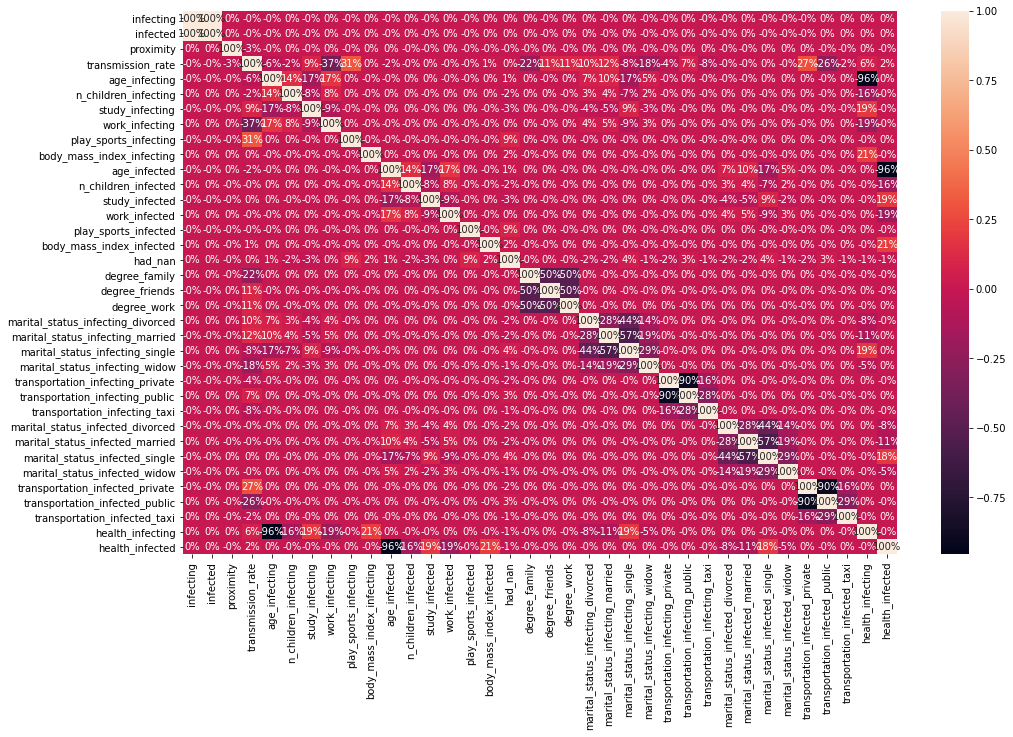

In [5]:
# Pearson's correlation
plt.figure(figsize=(16, 10))
_ = sns.heatmap(dataframe.corr(), annot=True, fmt=".0%")

In [6]:
# Remove high correlated features (> 70%)
dataframe_corr = dataframe.drop([
    'transportation_infected_public',
    'transportation_infecting_public',
    'age_infecting',
    'age_infected'
], axis=1)

In [7]:
# Feature selection model
dataframe_importance = dataframe_corr[(~dataframe_corr['transmission_rate'].isna())]
x = dataframe_importance.drop(['transmission_rate', 'infected', 'infecting', 'had_nan'], axis=1)
y = dataframe_importance['transmission_rate']

selection_model = RandomForestRegressor(
    n_estimators=5,
    criterion='mae',
    oob_score=True,
    random_state=1
)
_ = selection_model.fit(x.iloc[:10000], y.iloc[:10000])
# Limited the number o samples in order to speed up the process

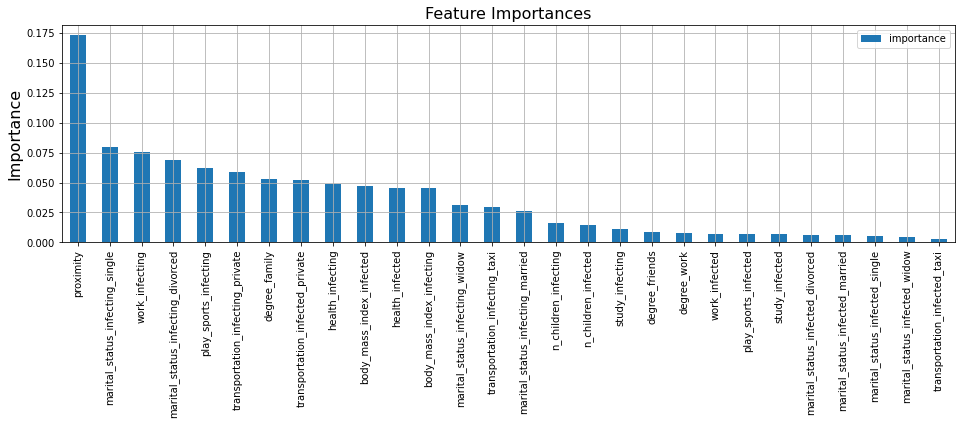

In [8]:
# Feature importance
importances = pd.Series(selection_model.feature_importances_, index=x.columns)
importances = importances.sort_values(ascending=False)
importances = importances / importances.apply(abs).sum()

plt.subplots(figsize=(16, 4))
importances.plot(kind='bar', label='importance')
plt.title('Feature Importances', size=16)
plt.ylabel('Importance', size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

In [9]:
# Remove features with low importance
dataframe_dropped = dataframe_corr.drop([
    'degree_work',
    'degree_friends',
    'study_infected',
    'play_sports_infected',
    'work_infected',
    'marital_status_infected_married',
    'marital_status_infected_divorced',
    'marital_status_infected_single',
    'marital_status_infected_widow',
    'transportation_infected_taxi'
], axis=1)

**Observations:**
- most of the features dropped come from the person who is transmitting the virus (infected)

## 2. Preprocessing

Let's save some of the data to evaluate our final model.

In [10]:
# Set aside the submission dataframe

# DISCLAIMER: I'll be dropping the training samples that had 
# missing values because I believe there's enough complete samples
# to train a fairly good model.

dataframe_modeling = dataframe_dropped[
    (~dataframe_dropped['transmission_rate'].isna()) &
    (dataframe_dropped['had_nan'] == False)
]

dataframe_submission = dataframe_dropped[dataframe_dropped['transmission_rate'].isna()]

print(f'modeling shape: {dataframe_modeling.shape}')
print(f'submission shape: {dataframe_submission.shape}')

modeling shape: (164467, 22)
submission shape: (500000, 22)


In [11]:
# Split dataset
x = dataframe_modeling.drop(['transmission_rate', 'infected', 'infecting', 'had_nan'], axis=1)
y = dataframe_modeling['transmission_rate']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print(f'train size: {len(x_train)}')
print(f'test size: {len(x_test)}')

train size: 115126
test size: 49341


In [12]:
# Significance level of the train set
_, p_value = ttest_ind(x, x_train)
for i, feature in enumerate(x):
    print(f'{feature}: {p_value[i]}')

proximity: 0.6316696598527088
n_children_infecting: 0.9228207904900925
study_infecting: 0.5453840572449151
work_infecting: 0.8061625098085052
play_sports_infecting: 0.9835844401033569
body_mass_index_infecting: 0.7834340032595385
n_children_infected: 0.8700580272394732
body_mass_index_infected: 0.7486201325479735
degree_family: 0.6512517196289911
marital_status_infecting_divorced: 0.8548205457984881
marital_status_infecting_married: 0.7445984034047451
marital_status_infecting_single: 0.5930791278003091
marital_status_infecting_widow: 0.508713749422073
transportation_infecting_private: 0.9238143011518518
transportation_infecting_taxi: 0.7948670273032798
transportation_infected_private: 0.7646646404915582
health_infecting: 0.819276817344627
health_infected: 0.5360768027952775


**Observations:**

- the significance level of the train set tells us that the distribution is similar to the whole dataset

## 3. Minimum Samples

Let's see if we can use only a subsample of our dataset to speed up the modeling.

In [13]:
# Plot learning curves
def plot_learining_curve(model_name, train_sizes, train_errors, validation_errors, fit_times):

    train_errors_mean = -1 * train_errors.mean(axis=1)
    validation_errors_mean = -1 * validation_errors.mean(axis=1)
    fit_times_mean = fit_times.mean(axis=1)

    train_errors_std = train_errors.std(axis=1)
    validation_errors_std = validation_errors.std(axis=1)
    fit_times_std = fit_times.std(axis=1)

    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

    ax[0].fill_between(
        train_sizes,
        train_errors_mean - train_errors_std,
        train_errors_mean + train_errors_std,
        alpha=0.1,
    )
    ax[0].plot(train_sizes, train_errors_mean, marker='o', label='training')
    ax[0].fill_between(
        train_sizes,
        validation_errors_mean - validation_errors_std,
        validation_errors_mean + validation_errors_std,
        alpha=0.1
    )
    ax[0].plot(train_sizes, validation_errors_mean, marker='o', label='validation')
    ax[0].set_title('Learning Curve', size=16)
    ax[0].set_ylabel(name, size=16)
    ax[0].set_xlabel('Number of Training Samples', size=16)
    ax[0].legend(loc='best')
    ax[0].grid(True)

    ax[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1
    )
    ax[1].plot(train_sizes, fit_times_mean, 'o')
    ax[1].set_title('Scalability of the Model', size=16)
    ax[1].set_ylabel('Fit Time (s)', size=16)
    ax[1].set_xlabel('Number of Training Samples', size=16)
    ax[1].grid(True)

    plt.show()

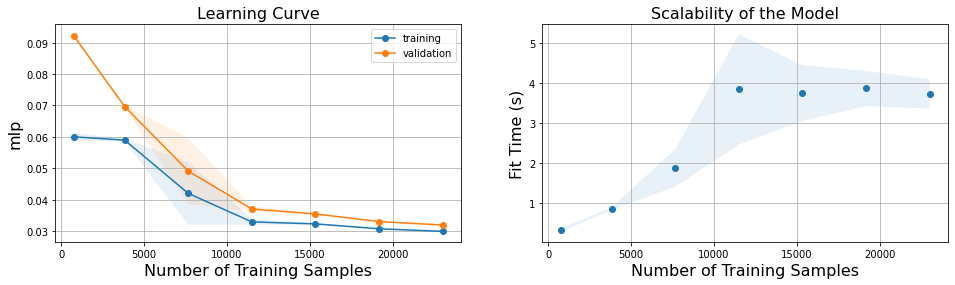

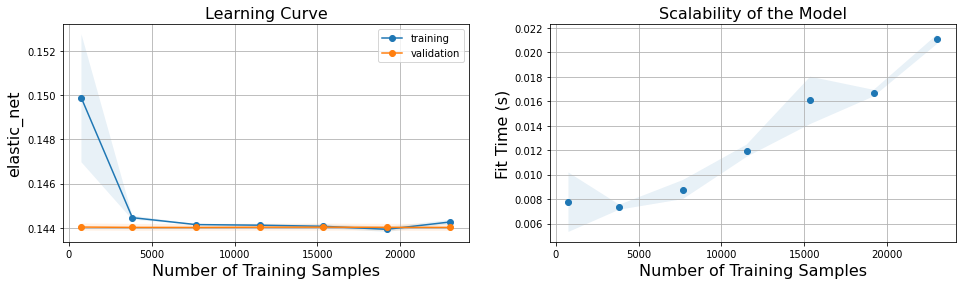

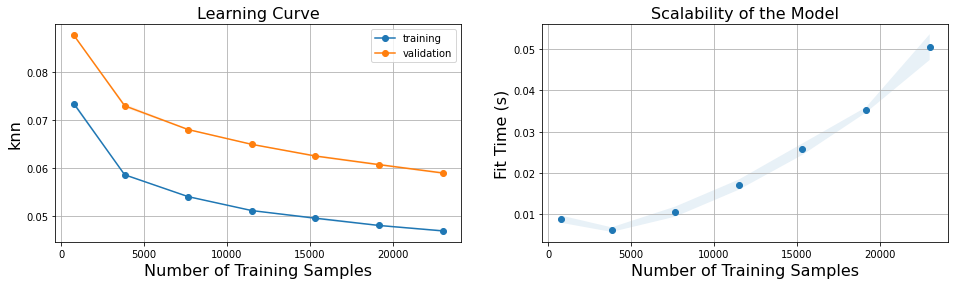

CPU times: user 9min 55s, sys: 14.5 s, total: 10min 9s
Wall time: 9min 47s


In [14]:
%%time

# Compute learning curves

# loop through models
for item in train.MODELS:
    name = item['name']
    model = item['model']

    # normalize
    scaler = StandardScaler()
    x_train_norm = scaler.fit_transform(x_train)
    
    # compute
    train_sizes, train_errors, validation_errors, fit_times, _ = learning_curve(
        model,
        x_train_norm,
        y_train,
        cv=3,
        train_sizes=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
        scoring='neg_mean_absolute_error',
        return_times=True
    )

    # plot
    plot_learining_curve(name, train_sizes, train_errors, validation_errors, fit_times)

In [15]:
# Select a subsample
N_SAMPLES = 30000
x_train_subsample = x_train.iloc[:N_SAMPLES]
y_train_subsample = y_train.iloc[:N_SAMPLES]

In [16]:
# Significance level of the new train set
_, p_value = ttest_ind(x_train, x_train_subsample)
for i, feature in enumerate(x_train):
    print(f'{feature}: {p_value[i]}')

proximity: 0.8556896324878481
n_children_infecting: 0.6281623354119055
study_infecting: 0.49503231159811667
work_infecting: 0.3673927762549709
play_sports_infecting: 0.5490877860654654
body_mass_index_infecting: 0.8787618502852184
n_children_infected: 0.34000634648526273
body_mass_index_infected: 0.3577114946633836
degree_family: 0.18670149856674365
marital_status_infecting_divorced: 0.31965345855946076
marital_status_infecting_married: 0.1410496149661005
marital_status_infecting_single: 0.7572445137301378
marital_status_infecting_widow: 0.6777348923042235
transportation_infecting_private: 0.885296318287907
transportation_infecting_taxi: 0.9799626578907459
transportation_infected_private: 0.29124603414177863
health_infecting: 0.6267338224225117
health_infected: 0.9418784722091109


**Observations:**

- even though the errors didn't get to a stable value, a subsample of the training set was selected in order to speed up our training process
- the SVM algorithm takes more time to be trained
- the MLP algorithm reaches the lowest error without any hyperparameter tunning

## 4. Evaluation

Now let's train the model and evaluate the results.

In [17]:
# Evaluation function
def evaluate(y, y_hat):

    # statistical test
    y = y.reshape(1, -1)
    y_hat = y_hat.reshape(1, -1)
    errors = (y - y_hat).reshape(-1, 1)
    _, p_value = shapiro(errors)
    
    # plot
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

    ax[0].scatter(y[0, :], errors)
    ax[0].set_xlabel('Expected Value', size=16)
    ax[0].set_ylabel('Absolute Error', size=16)
    ax[0].set_title(
        f'mean = {errors.mean()}\nstd = {errors.std()}', size=16)
    ax[0].grid()

    ax[1].hist(errors[:, 0], bins=100)
    ax[1].set_xlabel('Error', size=16)
    ax[1].set_ylabel('Count', size=16)
    ax[1].set_title(f'p-value = {p_value}', size=16)

In [18]:
%%time

# Train

# It may take a while, since some of the models take more time to train

train.run(x_train_subsample.values, y_train_subsample.values)

CPU times: user 29min 46s, sys: 27.1 s, total: 30min 13s
Wall time: 28min 24s


In [19]:
# Print results
dataframe_results = pd.DataFrame()
for item in train.MODELS:
    with open(f'{MODELS_PATH}/{item["name"]}.pkl', 'rb') as file:
        results = pickle.load(file)
        results.pop('model')
        dataframe_results[item['name']] = pd.Series(results)
dataframe_results

,mlp,elastic_net,knn
train_mean,0.001702,0.021804,0.005519
train_std,0.000071,0.000191,0.000048
validation_mean,0.001792,0.021843,0.008731
validation_std,0.000117,0.000505,0.000097


In [20]:
# Select model
MODEL_SELECTED = 'mlp'

In [21]:
# Predict
y_hat = predict.run(x_train_subsample.values, MODEL_SELECTED)

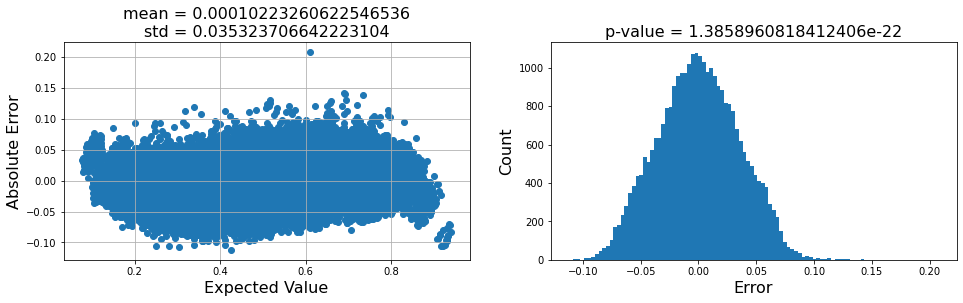

In [22]:
# Evaluate
evaluate(y_train_subsample.values, y_hat)

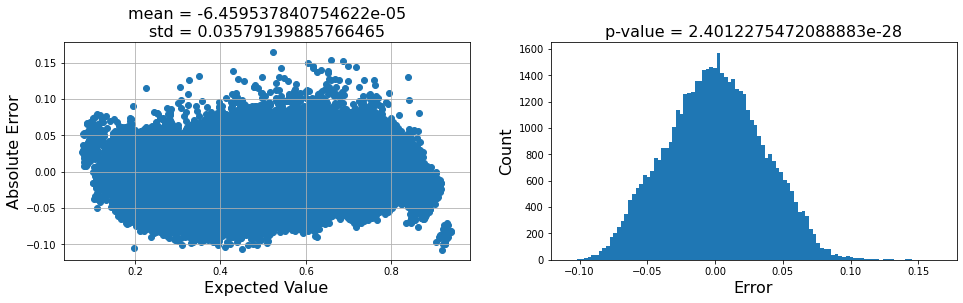

In [23]:
# Test
y_hat = predict.run(x_test.values, MODEL_SELECTED)
evaluate(y_test.values, y_hat)

In [24]:
# Submission

# compute
x_submission = dataframe_submission.drop(['transmission_rate', 'infected', 'infecting', 'had_nan'], axis=1)
y_submission = dataframe_submission['transmission_rate']

y_submission = predict.run(x_submission.values, MODEL_SELECTED)

# save
submission = dataframe_submission[['infected']]
submission['transmission_rate'] = y_submission
submission.to_csv('../submission/submission.csv', sep=';', decimal='.', index=False, header=False)

In [25]:
# Complete dataset with missing transmission rates
dataframe_completed = dataframe.copy()
dataframe_completed.loc[dataframe_submission.index, 'transmission_rate'] = y_submission
print(f'number of missing values: {dataframe_completed.isna().sum().sum()}')

number of missing values: 0


In [26]:
# Save new dataset
dataframe_completed.to_csv(f'{DATASETS_PATH}/dataframe_modeling.csv', index=False)

**Observations:**
- MLP was chosen due to its low errors in the train and valuation set
- the test errors are fairly gaussian distributed
- the model was able to capture the features relationship
- most of the test errors are between -10% and 10%